In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import numpy as np
import scipy as sp
import scipy.stats
import pickle
import os.path
import sys

import theano
import theano.tensor as T
# from theano.compile.nanguardmode import NanGuardMode
# from lasagne.updates import adam

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib.ticker import FormatStrFormatter
from IPython import display

size = matplotlib.rcParams['figure.figsize']
matplotlib.rcParams['figure.figsize'] = [size[0] * 1.5, size[1]* 1.5]

In [3]:
### utilities

def sample_categorical(pi, axis = -1, keepdims = False):
    pi_cumsum = pi.cumsum(axis = axis)
    samples = np.apply_along_axis( \
        lambda a: a.searchsorted(np.random.uniform(0, 1)), \
        arr = pi_cumsum, \
        axis = axis, \
    )
    if keepdims:
        return np.expand_dims(samples, axis = axis)
    else:
        return samples
    
def one_hot_last_axis(values, C):
    return (np.arange(C) == np.expand_dims(values, axis = -1)).astype(int)

def T_logsumexp(x, axis = None, keepdims = False):
    xm = x.max(axis = axis, keepdims = True)
    return T.log(T.exp(x - xm).sum(axis = axis, keepdims = keepdims)) + xm


def init_T_weight(n_in, n_out, name, is_sigmoid = False, is_zero = False):
    if is_zero:
        value = np.zeros((n_in, n_out), dtype = theano.config.floatX)
    else:
        value = np.asarray(
            np.random.uniform(
                low = -np.sqrt(6. / (n_in + n_out)),
                high = np.sqrt(6. / (n_in + n_out)),
                size = (n_in, n_out)
            ),
            dtype = theano.config.floatX
        )
    if is_sigmoid:
        value *= 4
    w = theano.shared(value = value, name = name + '_w', borrow = True)
    b = theano.shared(
        value = np.zeros((n_out,), dtype = theano.config.floatX),
        name = name + '_b',
        borrow = True,
    )
    return w, b

In [4]:
# 2d gmm w/ fixed isotropic variance and fixed cluster distn cluster means have same prior.
# infer Pr[cluster means | samples]

### HYPER PARAMETERS ###

# C num clusters Uniform[1, C_max]
C_max = 8

# mu[i] ~ Gaussian(mu_mu[i], mu_Sigma[i])
mu_mu = np.zeros((2,))
mu_sigma2 = 4
mu_Sigma = np.eye(2) * mu_sigma2
mu_Lambda = np.eye(2) / mu_sigma2
mu_rv = sp.stats.multivariate_normal(mu_mu, mu_Sigma)

# sigma2 fixed
sigma2 = 0.1
Sigma = np.eye(2) * sigma2
Lambda = np.eye(2) / sigma2

# pi uniform categorical over clusters
# pi_prob = 1 / C
# pis = np.arange(C)
# pi_rv = sp.stats.bernoulli(pi_eq_1_prob)

# sample number n, fixed for NN
n = 60

### SAMPLE ###

def xs_1d_pca(xs):
#     return (xs ** 2).sum(axis = 2), None, None
    offsets_3d = xs.mean(axis = 1, keepdims = True)  # (k, 1, 2)
    zero_mean_xs = xs - offsets_3d
    Ts = []
    Ws = []
    for i in range(xs.shape[0]):
        U, s, V = np.linalg.svd(zero_mean_xs[i], full_matrices = False)
        T, W = U[:, 0] * s[0], V[0]
        if W[0] <= 0:
            T, W = -T, -W
        Ws.append(W)
        Ts.append(T)
    return np.stack(Ts), np.stack(Ws), offsets_3d

# if mus_valid_bits or zs is None, they won't be changed
def sort_mus_pca(mus, mus_valid_bits, zs, Ws, offsets_3d, get_argsort = False):
    k = mus.shape[0]
    vertical_k_idxs = np.arange(k)[:, None]
    mus_1d = np.einsum('ijk,ik->ij', mus - offsets_3d, Ws) # transform mus to 1d
#     mus_1d = (mus ** 2).sum(axis = 2)
    mus_1d_argsort = mus_1d.argsort()
    mus = mus[vertical_k_idxs, mus_1d_argsort]
    if mus_valid_bits is not None:
        mus_valid_bits = mus_valid_bits[vertical_k_idxs, mus_1d_argsort]
    if zs is not None:
        zs = mus_1d_argsort.argsort()[vertical_k_idxs, zs]
    if not get_argsort:
        return mus, mus_valid_bits, zs
    else:
        return mus, mus_valid_bits, zs, mus_1d_argsort

def sort_xs_pca(zs, xs, Ts):
    k = xs.shape[0]
    vertical_k_idxs = np.arange(k)[:, None]
    Ts_argsort = Ts.argsort() # xs order by first principle component
    xs = xs[vertical_k_idxs, Ts_argsort]
    zs = zs[vertical_k_idxs, Ts_argsort]
    return zs, xs

# Essentially (observation, hidden) pair
# For clusters w/ indices > random C, mu values are random from prior but don't convey any info
def sample(k = 1, Cs = None, sort_pca = False):
    if not Cs:
        Cs = np.random.choice(C_max, size = (k, 1)) + 1
    else:
        Cs = np.atleast_2d(Cs).reshape((k, 1)).astype(int)
        assert Cs.min() > 0 and Cs.max() <= C_max
    mus = mu_rv.rvs(size = (k, C_max)).reshape((k, C_max, 2))
    mus_valid_bits = np.zeros((k, C_max), dtype = int)
    for i in range(k):
        mus_valid_bits[i, :Cs[i, 0]] = 1
    zs = np.stack(np.random.choice(Cs[i, 0], size = n) for i in range(k))
    xs = np.random.multivariate_normal(np.zeros(2), np.eye(2), size = (k, n)) \
        * np.sqrt(sigma2) + mus[np.arange(k)[:, None], zs]
    if sort_pca:
        Ts, Ws, offsets_3d = xs_1d_pca(xs)
#         mus_non_cluster_x_inf = mus.copy()
#         for i in range(k):
#             mus_non_cluster_x_inf[i, Cs[i, 0]:, 0] = np.inf
        mus, mus_valid_bits, zs = sort_mus_pca(mus, mus_valid_bits, zs, Ws, offsets_3d)
#         for i in range(k):
#             sorted_mus[i, Cs[i, 0]:] = mus[i, Cs[i, 0]:]
        zs, xs = sort_xs_pca(zs, xs, Ts)
        return Cs, mus, mus_valid_bits, zs, xs, Ws, offsets_3d.squeeze(axis = 1)
    return Cs, mus, mus_valid_bits, zs, xs

# un-(pca)-sort for gibbs
def permute_valid_mus_front(Cs, mus, mus_valid_bits, zs, xs):
    k = Cs.shape[0]
    unorder = (-mus_valid_bits).argsort(axis = 1)
    unorder_mus = mus[np.arange(k)[:, None], unorder]
    unorder_mus_valid_bits = mus_valid_bits[np.arange(k)[:, None], unorder]
    unorder_zs = unorder.argsort(axis = 1)[np.arange(k)[:, None], zs]
    return Cs, unorder_mus, unorder_mus_valid_bits, unorder_zs, xs

# input assumed valid
# ignore constant terms:
#     P[C]
def get_log_likelihood(Cs, mus, mus_valid_bits, zs, xs):
    k = xs.shape[0]
    l = np.zeros((k, 1))
    # mus
    l += (np.atleast_2d(mu_rv.logpdf(mus)) * mus_valid_bits).sum(axis = 1, keepdims = True)
    # zs
    l -= np.log(Cs) * n
    # xs
    l -= np.square(xs - mus[np.arange(k)[:, None], zs]).sum(axis = 2).sum(axis = 1, keepdims = True) / (2 * sigma2)
    return l

# input assumed valid
# ignore constant terms:
#     P[C]
def get_log_likelihood_no_zs(Cs, mus, mus_valid_bits, xs):
    k = xs.shape[0]
    l = np.zeros((k, 1))
    # mus (k, C_max, 2)
    l += (np.atleast_2d(mu_rv.logpdf(mus)) * mus_valid_bits).sum(axis = 1, keepdims = True)
    # xs (k, n, 2)
    xs_ls = -np.square(xs[:, :, None, :] - mus[:, None, :, :]).sum(axis = 3) / (2 * sigma2)   # (k, n, C_max)
    mus_valid_bits, _ = np.broadcast_arrays(np.invert(mus_valid_bits.astype(bool))[:, None, :], xs_ls)
    xs_ls[mus_valid_bits] = -np.inf     # set invalid mus with prob 0
    l += sp.misc.logsumexp(xs_ls, axis = 2).sum(axis = 1) - n * np.log(Cs)
    return l

In [5]:
# Test get_log_likelihood_* fns. Use with n small.

# from itertools import product

# Cs, mus, mus_valid_bits, zs, xs = sample(1, Cs = 10)

# print(Cs, mus, mus_valid_bits, zs)

# print(get_log_likelihood(Cs, mus, mus_valid_bits, zs, xs)[0, 0])

# C = Cs[0, 0]
# ls = []
# for z_vals in product(range(C), repeat = n):
#     t_zs = np.array(z_vals, dtype = int)[None, :]
#     ls.append(get_log_likelihood(Cs, mus, mus_valid_bits, t_zs, xs))
# print(sp.misc.logsumexp(ls))

# print(get_log_likelihood_no_zs(Cs, mus, mus_valid_bits, xs)[0, 0])

In [6]:
### PLOT ###

COLOR_CYCLE = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']

# Test initialization w/ different numbers of clusters
def compare_mcmc_different_init_clusters(samples = None, start_samples = None, **args):
    if samples is None:
        samples = sample(1, sort_pca = True)
    if start_samples is None:
        start_samples = [sample(1, Cs = c, sort_pca = True) for c in range(1, C_max + 1)]
        
    assert samples[0].shape[0] == 1
    true_c = samples[0][0, 0]

    subplot_shape = (np.ceil(C_max / 2).astype(int), 2)
    fig = plt.figure(figsize = (subplot_shape[1] * 6, subplot_shape[0] * 6))
    fig.suptitle("MCMC Comparison on Data with {} Cluster{}".format(true_c, "s" if true_c > 1 else ""), y = 0.90)

    true_log_likelihood = get_log_likelihood(*samples[:5])[0, 0]

    for c in range(1, C_max + 1):
        ax = fig.add_subplot(*subplot_shape, c)
        true_hline = ax.axhline(y = true_log_likelihood, color = "red", alpha = 0.6)
        true_hline.set_label("True data")
        
        start_sample = start_samples[c - 1]
        assert start_sample[0].shape[0] == 1 and start_sample[0][0, 0] == c

        compare_mcmc(
            samples[4], 
            title = "MCMC Log Likelihood Comparison with {} Initial Cluster{}".format(c, "s" if c > 1 else ""),
            ax = ax,
            plt_close = False,
            init_fn = lambda: start_sample[:5], 
            **args
        )
        
    plt.close()
    return samples

def compare_mcmc(xs, title = "MCMC Log Likelihood", ax = None, plt_close = True, **args):
    plotter = LinePlotter(title, "linear", ax = ax)
    gibbs(xs, plotter = plotter, **args)
    nn_block_mh(xs, plotter = plotter, **args)
    plotter.finish_all(plt_close = plt_close)

def test_pretrain_visualize(true_samples = None, current_samples = None):
    # samples are (Cs, mus, mus_valid_bits, zs, xs, Ws, offsets)
    if true_samples is None:
        true_samples = sample(1, sort_pca = True)
    if current_samples is None:
        current_samples = sample(1, sort_pca = True)
    assert true_samples[0].shape[0] == current_samples[0].shape[0] == 1
    
    subplot_shape = (np.ceil(C_max / 2).astype(int), 2)
    fig = plt.figure(figsize = (subplot_shape[1] * 6, subplot_shape[0] * 6)) 
    
    for prop_mu_start_idx in range(0, C_max - 1):
        input_data, prop_data = sample_to_train_data(
            *(current_samples[:4] + true_samples[4:]), 
            prop_mu_start_idxs = np.atleast_2d(prop_mu_start_idx)
        )
        ax = fig.add_subplot(*subplot_shape, prop_mu_start_idx + 1)
        test_pretrain_visualize_single(input_data, ax = ax)
        ax.set_title("mus_prop_bits = {}".format(input_data[-3][0]))

def test_pretrain_visualize_single(input_data = None, ax = None):
    ax = plt.gca() if ax is None else ax
    if input_data is None:
        Cs, mus, mus_valid_bits, zs, xs, Ws, offsets = samples = sample(1, sort_pca = True)
        input_data, output_prop_data = sample_to_train_data(*samples)
    flat_pxs, flat_input_mus, input_valid_bits, input_prop_bits, Ws, offsets = input_data
    xs = flat_pxs.reshape((n, 2))
    input_mus = flat_input_mus.reshape((C_max, 2))
    input_prop_bits = input_prop_bits[0]
    input_valid_bits = input_valid_bits[0]
    # inputs xs
    scatter_xs(xs, alpha = 0.3, linewidth = 0, ax = ax)
    # prop mus distns
    distns = prop_mdn.get_distns(*input_data)
    contour_distns(distns, colors = COLOR_CYCLE, ax = ax)
    # input mus
    for c in range(C_max):
        if input_prop_bits[c] == 0 and input_valid_bits[c] == 1:
            scatter_xs(input_mus[c], color = 'white', marker = '*', edgecolor = 'black', linewidth = 0.5, s = 80, ax = ax)
    ax.axis('equal')
    
class LinePlotter:
    def __init__(self, title, yscale = 'log', ax = None, grid = False):
        self.data = []
        self.lines = []
        self.is_actives = []
        self.update_intervals = []
        self.title = title
        self.yscale = yscale
        self.ax = plt.gca() if ax is None else ax
        self.ax.set_title(self.title)
        self.ax.set_yscale(self.yscale)
        if 'log' in self.yscale:
            self.ax.get_yaxis().get_major_formatter().labelOnlyBase = False
        if grid:
            self.ax.grid()
            
    # returns a line index for update/finish calls
    def add_line(self, label, data = None, update_interval = 50):
        idx = len(self.data)
        if data is None:
            data = [], []
        self.data.append(data)
        line, = self.ax.plot(*self.data[-1])
        self.lines.append(line)
        line.set_label(label)
        self.update_intervals.append(update_interval)
        self.is_actives.append(True)
        self.ax.legend()
        self.draw(idx)
        return idx
            
    def get_label_data(self, idx):
        return self.lines[idx].get_label(), self.data[idx]

    def draw(self, idx):
        assert self.is_actives[idx]
        self.lines[idx].set_xdata(self.data[idx][0])
        self.lines[idx].set_ydata(self.data[idx][1])
        self.ax.relim()
        self.ax.autoscale_view()
        display.clear_output(wait = True)
        display.display(plt.gcf())

    def update(self, idx, x, y, force = False):
        self.data[idx][0].append(x)
        self.data[idx][1].append(y)
        if force or len(self.data[idx][0]) % self.update_intervals[idx] == 0:
            self.draw(idx)

    def finish(self, idx):
        if self.is_actives[idx]:
            self.draw(idx)
            self.is_actives[idx] = False
    
    def finish_all(self, plt_close = True):
        for idx in range(len(self.data)):
            self.finish(idx)
        plt.ioff()
        if plt_close:
            plt.close()

def contour_distns(distns, margin = 2, delta = 100j, colors = COLOR_CYCLE, ax = None, **countour_args):
    ax = plt.gca() if ax is None else ax
    xmin, xmax, ymin, ymax = ax.axis()
    X, Y = np.mgrid[
        xmin - margin : xmax + margin : delta, 
        ymin - margin : ymax + margin : delta,
    ]
    a = distns[0][0]
    mus_mu_distns = distns[1][0]
    mus_sigma2_distns = distns[2][0]
    mus_valid_distns = distns[3][0]
    mus_p = [0 for _ in range(prop_mdn.block_prop_C)]
    for nn_c in range(prop_mdn.C):
        for c in range(prop_mdn.block_prop_C):
            mu_mu = mus_mu_distns[nn_c, c]
            mu_sigma = np.sqrt(mus_sigma2_distns[nn_c, c])
            mus_p[c] += a[nn_c] * mus_valid_distns[nn_c, c] * mlab.bivariate_normal(X, Y, mu_sigma, mu_sigma, *mu_mu)
    mus_valid_distns_all = mus_valid_distns.mean(axis = 0)
    for c in range(prop_mdn.block_prop_C):
        mu_contour = ax.contour(X, Y, mus_p[c], 6, colors = colors[c % len(colors)], alpha = mus_valid_distns_all[c], **countour_args)
        ax.clabel(mu_contour, fontsize = 9, inline = 1)

def scatter_xs(xs, zs = None, color = 'black', ax = None, **scatter_args):
    assert zs is None or zs.shape[0] == 1
    ax = plt.gca() if ax is None else ax
    n = int(xs.size / 2)
    if len(xs.shape) != 2:
        xs = xs.reshape((n, 2))
    if zs is None:
        ax.scatter(xs[:, 0], xs[:, 1], color = color, **scatter_args)
    else:
        zs = zs.reshape(n)
        for c in range(C):
            xcs = xs[zs == c]
            ax.scatter(xcs[:, 0], xcs[:, 1], color = COLOR_CYCLE[c % len(COLOR_CYCLE)], edgecolor = 'black', linewidth = '1', **scatter_args)
    ax.axis('equal')
            
def sample_mus_kde(xs, samples, gaussian_bw = 0.2, margin = 2, delta = 100j, ax = None):
    ax = plt.gca() if ax is None else ax
    sample_mus = np.vstack([
            sample[1][0][sample[2][0].astype(bool)] for sample in samples   # sample[1] is mus, sample[2] is mus_valid_bits
        ])
    kernel = sp.stats.gaussian_kde(sample_mus.T, bw_method = gaussian_bw)
    xmin = xs[0, :, 0].min() - margin
    xmax = xs[0, :, 0].max() + margin
    ymin = xs[0, :, 1].min() - margin
    ymax = xs[0, :, 1].max() + margin
    X, Y = np.mgrid[xmin:xmax:delta, ymin:ymax:delta]
    positions = np.vstack([X.ravel(), Y.ravel()])
    Z = kernel(positions).reshape(X.shape)
    ax.imshow(np.rot90(Z), cmap = plt.cm.gist_earth_r, extent=[xmin, xmax, ymin, ymax])
    scatter_xs(xs[0], color = 'black', alpha = 0.3, linewidth = 0, ax = ax)
    scatter_xs(sample_mus, color = 'white', alpha = 0.8, marker = '*', edgecolor = 'black', linewidth = 0.5, s = 80, ax = ax)
    
def sample_Cs_hist(Cs, samples, ax = None):
    ax = plt.gca() if ax is None else ax
    info = ax.hist(np.vstack([sample[0] for sample in samples]), align='left', bins = np.arange(1, C_max + 2))
    
    # color true bar orange
    C = Cs[0, 0]
    patches = info[2]
    min_dist = np.inf
    index_of_bar_of_C = 0
    for i, rectangle in enumerate(patches):  # iterate over every bar
        dist = abs((rectangle.get_x() + rectangle.get_width() / 2) - C)
        if dist < min_dist:
            min_dist = dist
            index_of_bar_of_C = i
    patches[index_of_bar_of_C].set_color('orange')

In [7]:
### Gibbs ###

# Pack valid cluster means at front of mus

# xs are fixed observations
# C   int
# mus (C_max, 2)
# zs  (n,)
# xs  (n, 2)
def gibbs_step(C, mus, zs, xs):
    # C
    probs_with_C = np.zeros(C_max) - np.inf
    for new_C in range(1, C_max + 1):
        if new_C <= zs.max():
            continue
        probs_with_C[new_C - 1] = get_log_likelihood(
            np.atleast_2d(new_C),
            mus[None, :, :], 
            np.atleast_2d([1] * new_C + [0] * (C_max - new_C)),      # mus_valid_bits. valid mus are up front
            zs[None, :], 
            xs[None, :, :]
        )
    probs_with_C -= probs_with_C.max()
    probs_with_C = np.exp(probs_with_C)
    probs_with_C /= probs_with_C.sum()
    new_C = sample_categorical(probs_with_C) + 1
    # mus
    new_mus = []
    ## valid ones from posterior
    for c in range(new_C):
        x_cs = xs[zs == c]
        t = np.linalg.inv(mu_Lambda + x_cs.shape[0] * Lambda)
        new_mu = np.random.multivariate_normal( \
            t.dot(mu_Lambda.dot(mu_mu) + Lambda.dot(x_cs.sum(axis = 0))), \
            t, \
        )
        new_mus.append(new_mu)
    valid_new_mus = np.stack(new_mus)
    ## invalid ones from just prior
    new_mus = np.vstack([valid_new_mus, mu_rv.rvs(C_max - new_C)])
    # zs
    x_mus_2norm = ((xs.reshape((n, 1, 2)) - valid_new_mus) ** 2).sum(axis = 2)
    unnormalized_probs_z = np.exp(- x_mus_2norm  / (2 * sigma2))
    probs_z = unnormalized_probs_z / (unnormalized_probs_z.sum(axis = 1, keepdims = True))
    new_zs = sample_categorical(probs_z).flatten()
    return new_C, new_mus, new_zs

def gibbs(xs, init_fn = sample, num_samples = 500, sample_int = 10, \
          burn_in = 5000, plotter = None, plot_interval = 50):
    xs, xs_3d = xs.reshape((n, 2)), xs.reshape((1, n, 2))
    s_Cs = []
    s_mus = []
    s_mus_valid_bits = []
    s_zs = []
    Cs, mus, _, zs = permute_valid_mus_front(*init_fn()[:5])[:4]
    C, mus, zs = Cs[0, 0], mus[0], zs[0]
    if plotter is not None:
        plotter_idx = plotter.add_line("Gibbs", update_interval = plot_interval)
        def update_plot(t):
            plotter.update( \
                plotter_idx, \
                t, \
                get_log_likelihood_no_zs( \
                    np.atleast_2d(C),
                    mus.reshape((1, C_max, 2)), \
                    np.atleast_2d([1] * C + [0] * (C_max - C)),      # mus_valid_bits. valid mus are up front \
#                     np.atleast_2d(zs), \
                    xs_3d, \
                )[0, 0], \
            )
        update_plot(0)
    for t in range(burn_in + num_samples * sample_int):
        if t >= burn_in and (t - burn_in) % sample_int == 0:
            s_Cs.append(C)
            s_mus.append(mus)
            s_mus_valid_bits.append(np.array([1] * C + [0] * (C_max - C)))
            s_zs.append(zs)
        C, mus, zs = gibbs_step(C, mus, zs, xs)
        if plotter is not None:
            update_plot(t + 1)
    if plotter is not None:
        plotter.finish(plotter_idx)
    if num_samples > 0:
        return np.array(s_Cs)[:, None], np.stack(s_mus), np.stack(s_mus_valid_bits), np.stack(s_zs)

In [8]:
class MDN:
    # layers contains [(num_cells, act_fn), ...]
    def __init__(self, name, num_in, layers, C, num_out_per_C, num_distns_per_C):
        # last layer's activation should be handled by self.T_out_to_distns
        assert layers[-1] == (C + C * num_out_per_C, None) 
        self.name = name
        self.num_in = num_in
        self.layers = layers
        self.C = C
        self.num_out_per_C = num_out_per_C
        self.num_distns_per_C = num_distns_per_C
        self.init_layers()
        self.init_utility_fns()
        
    def init_layers(self):
        self.layer_weights = []
        num_last = self.num_in
        for i, (num_cells, act_fn) in enumerate(self.layers):  
            w, b = init_T_weight(num_last, num_cells, self.name + '_{}_{}'.format(i, i + 1))
            self.layer_weights.append((w, b))
            num_last = num_cells
        self.layer_weights = tuple(self.layer_weights)
        self.weights = sum(self.layer_weights, ())
        
    def forward(self, T_in):
        T_last = T_in
        for i, ((num_cells, act_fn), (w, b)) in enumerate(zip(self.layers, self.layer_weights)):
            if act_fn is None:
                T_last = T_last.dot(w) + b
            else:               
                T_last = act_fn(T_last.dot(w) + b)
        return self.T_out_to_distns(T_last)
                
    def T_out_to_distns(self, T_out):
        at = 0
        pi_distn = T.nnet.softmax(T_out[:, at : at + self.C])
        at += self.C
        C_distns_coll = [[] for _ in range(self.num_distns_per_C)]
        for _ in range(self.C):
            C_distns = self.T_mixture_out_to_distns(T_out[:, at : at + self.num_out_per_C])
            for coll, distn in zip(C_distns_coll, C_distns):
                coll.append(distn)
            at += self.num_out_per_C
        return [pi_distn] + [T.stack(coll, axis = 1) for coll in C_distns_coll]
    
    def T_mixture_out_to_distns(self, T_mixture_out):
        raise NotImplementedError
    
    def T_log_probs(self, T_distns, *sample_tensors):
        k = sample_tensors[0].shape[0]
        a, mixture_distns = T_distns[0], T_distns[1:]
        cluster_log_probs = []
        for c in range(self.C):
            cluster_log_probs.append(
                T.log(a[:, c])[:, None] + \
                self.T_mixture_log_prob([distn[:, c] for distn in mixture_distns], *sample_tensors)
            )
        return T.concatenate(cluster_log_probs, axis = 1)
    
    def T_mixture_log_prob(self, T_mixture_distns, *sample_tensors):
        raise NotImplementedError
        
    def init_utility_fns(self):
        self.get_weights = theano.function([], self.weights)
        file_layer_weights = [(T.dmatrix(w.name + '_file'), T.dvector(b.name + '_file')) for w, b in self.layer_weights]
        file_weights = sum(file_layer_weights, ())
        self.set_weights = theano.function( \
            file_weights, \
            file_weights, \
            updates = list(zip(self.weights, file_weights)), \
        )
                                           
    def dump_weights(self, suffix):
        file_name = "{}_{}.pkl".format(self.name, suffix)
        if os.path.isfile(file_name):
            print("{} already exists, abort.".format(file_name))
            return
        with open(file_name, 'wb') as f:
            pickle.dump(self.get_weights(), f)
        print('Dumped to file {}'.format(file_name))

    def load_weights(self, suffix):
        file_name = "{}_{}.pkl".format(self.name, suffix)
        with open(file_name, 'rb') as f:
            self.set_weights(*pickle.load(f))
        print('Loaded from file {}'.format(file_name))
        
    

In [9]:
### Block Proposal NN ###
# Propose block_prop_C clusters given observations, all other clusters, and all
# assignments to other clusters.

# Prop NN
# Parmetrize variable cluster nums as C_max cluster means and a bit map.
# Propose 2 clusters (mean + valid bit) each time
# Input: xs, C_max * (mean, valid bit, proposing bit), Ws, offsets
#        if proposing bit == 1, mean and valid bit = 0
# Output: MDN of 2 * (prop_mean mu, prop_mean sigma2, prop_mean valid bit prob)
class BlockPropMDN(MDN):
    MIN_SIGMA2 = 0.00001
    L1_reg = 0.0001

    def __init__(self):
        self.block_prop_C = 2
        nn_C = 4
        n_in = C_max * 4 + n * 2 + 2 + 2
        n_mixture_out = self.block_prop_C * 4
        n_out = nn_C + nn_C * n_mixture_out
        n_mid1 = max(n_in, n_out) * 4
        n_mid2 = max(n_in, n_out) * 4

        n_distns_per_C = 3      # gathered mu, gathered sigma2, gathered valid bit probs

        MDN.__init__(
            self,
            "prop_mdn", 
            n_in,
            [
                (n_mid1, T.nnet.elu),
                (n_mid2, T.nnet.elu),
                (n_out, None),
            ], 
            nn_C, 
            n_mixture_out,
            n_distns_per_C,
        )

        # batch size k

        ## inputs
        self.flat_pxs = T.dmatrix('flat_pxs')                     # (k, n * 2)
        self.flat_input_mus = T.dmatrix('flat_input_mus')         # (k, C_max * 2) prop_mus have 0
        self.input_valid_bits = T.dmatrix('input_valid_bits')     # (k, C_max) prop_mus have 0
        self.input_prop_bits = T.dmatrix('input_prop_bits')       # (k, C_max) prop_mus have 0
        self.Ws = T.dmatrix('Ws')                                 # (k, 2) = pca weights of xs
        self.offsets = T.dmatrix('offsets')                       # (k, 2) = pca offsets of xs

        ## props
        self.prop_valid_bits = T.dmatrix('prop_valid_bits')       # (k, block_prop_C) = processed proposing zs
        self.flat_prop_mus = T.dmatrix('flat_prop_mus')           # (k, block_prop_C * 2) = mus + hids
        
        self.input_tensors = [
            self.flat_pxs, 
            self.flat_input_mus, 
            self.input_valid_bits, 
            self.input_prop_bits,
            self.Ws, 
            self.offsets,
        ]
        self.output_prop_tensors = [
            self.flat_prop_mus,
            self.prop_valid_bits, 
        ]
        self.all_tensors = self.input_tensors + self.output_prop_tensors
        
        
        self.output_prop_tensors_reverse = [
            self.flat_prop_mus[:, ((np.arange(self.block_prop_C) * 2)[::-1, None] + np.arange(2)).flatten()],
            self.prop_valid_bits[:, np.arange(self.block_prop_C)[::-1]], 
        ]
        
        # ``forward''
        T_in = self.T_nn_input(*self.input_tensors)
        T_distns = self.forward(T_in)
        mixture_prop_log_probs = self.T_log_probs(T_distns, *self.output_prop_tensors)
        mixture_prop_log_probs_reverse = self.T_log_probs(T_distns, *self.output_prop_tensors_reverse)
        prop_log_prob = T_logsumexp(
            T.concatenate([mixture_prop_log_probs, mixture_prop_log_probs_reverse], axis = 1),
            axis = 1, 
            keepdims = True,
        )
        
#         # ``backward''
#         T_back_in = self.T_nn_input(*self.input_tensors)
#         distns = self.forward(T_in)
#         mixture_prop_log_probs = self.T_mixture_prop_log_probs(distns, *self.output_prop_tensors)
#         prop_log_prob = T_logsumexp(mixture_prop_log_probs, axis = 1, keepdims = True)

        self.get_distns = theano.function(self.input_tensors, T_distns)
        self.get_prop_log_prob = theano.function(self.all_tensors, prop_log_prob)
        
        # NN training
        self.train_rate = T.dscalar('train_rate')

        # pretrain
        train_target = -prop_log_prob.mean() + self.L1_reg * sum(T.sum(abs(w)) for w, b in self.layer_weights)
        grads = tuple(T.grad(train_target, w) for w in self.weights)
        self.get_train_target = theano.function(self.all_tensors, train_target)
        self.get_train_grads = theano.function(self.all_tensors, grads)
        self.train = theano.function( \
            self.all_tensors + [self.train_rate], \
            [train_target, self.train_rate], \
            # updates = adam(-pretrain_target, x_weights),
            updates = [
                (w, w - self.train_rate * gw) for w, gw in zip(self.weights, grads)
            ],
            # mode = NanGuardMode(nan_is_error=True, inf_is_error=True, big_is_error=True)
        )
    
    def T_nn_input(self, *input_2d_tensors):
        return T.concatenate(input_2d_tensors, axis = 1)
    
    def T_mixture_out_to_distns(self, T_mixture_out):
        mus_mu_distns = []
        mus_sigma2_distns = []
        mus_valid_distns = []
        at = 0
        for _ in range(self.block_prop_C):
            mus_mu_distns.append(T_mixture_out[:, at : at + 2])
            at += 2
            mus_sigma2_distns.append(T.nnet.elu(T_mixture_out[:, at : at + 1]) + 1 + self.MIN_SIGMA2)
            at += 1
            mus_valid_distns.append(T.nnet.sigmoid(T_mixture_out[:, at : at + 1]))
            at += 1
        return T.stack(mus_mu_distns, axis = 1), \
            T.concatenate(mus_sigma2_distns, axis = 1), \
            T.concatenate(mus_valid_distns, axis = 1)
    
    def T_mixture_log_prob(self, T_mixture_distns, *sample_tensors):
        flat_prop_mus, prop_valid_bits = sample_tensors
        k = prop_valid_bits.shape[0]
        prop_mus = flat_prop_mus.reshape((k, self.block_prop_C, 2))
        # mus_mu_distns_c           (k, block_prop_C, 2)
        # mus_sigma2_distns_c       (k, block_prop_C)
        # mus_valid_bits_distns_c   (k, block_prop_C)
        mus_mu_distns_c, mus_sigma2_distns_c, mus_valid_bits_distns_c = T_mixture_distns
        # mu
        l_mu = (
            -T.sqr(prop_mus - mus_mu_distns_c).sum(axis = 2) / (2 * mus_sigma2_distns_c) - T.log(mus_sigma2_distns_c)
        ).sum(axis = 1, keepdims = True) # np.log(2 * np.pi) term ignored
        l = (T.log(mus_valid_bits_distns_c) + l_mu) * prop_valid_bits \
            + T.log(1 - mus_valid_bits_distns_c) * (1 - prop_valid_bits)
        return l
    
prop_mdn = BlockPropMDN()

# back_input_tensors = [flat_pxs, input_pzs, flat_prop_mus]
# back_output_prop_tensors = [flat_input_mus]

# ``backward'' using flat_prop_mus as part of input
# for backward proposal probability calculation in MH
# T_in_back = prop_mdn.T_nn_input(*back_input_tensors)
# mus_distns_back = prop_mdn.forward(T_in_back)
# mus_cluster_prop_log_probs_back = prop_mdn.T_mus_cluster_prop_log_probs(mus_distns_back, *input_prop_tensors)
# mus_prop_log_prob_back = T_logsumexp(mus_cluster_prop_log_probs_back, axis = 1, keepdims = True)

In [10]:
### Training Functions ###

# Cs and zs are actually unused, safe to put anything here
def sample_to_train_data(Cs, mus, mus_valid_bits, zs, xs, Ws, offsets, prop_mu_start_idxs = None):
    k = xs.shape[0]
    if prop_mu_start_idxs is None:
        prop_mu_start_idxs = np.random.choice(C_max - 1, size = (k, 1))                 # (k, 1)
    else: 
        assert prop_mu_start_idxs.max() < C_max - 1 and prop_mu_start_idxs.shape == (k, 1) 
    prop_mu_idxs = np.hstack([prop_mu_start_idxs, prop_mu_start_idxs + 1])              # (k, 2)
    prop_mus_mask = np.zeros((k, C_max), dtype = bool)              
    prop_mus_mask[np.arange(k)[:, None], prop_mu_idxs] = True                           # (k, C_max)
    
    # inputs are:
    #  [flat_pxs, flat_input_mus, input_valid_bits, input_prop_bits, Ws, offsets]
    
    # flat_pxs: flatten
    flat_pxs = xs.reshape((k, n * 2))
    
    # flat_input_mus: flatten, mask prop mus to 0 
    input_mus = mus.copy()
    input_mus[np.arange(k)[:, None], prop_mu_idxs] = 0
    flat_input_mus = input_mus.reshape((k, C_max * 2))
    
    # input_valid_bits
    input_valid_bits = mus_valid_bits.copy()
    input_valid_bits[np.arange(k)[:, None], prop_mu_idxs] = 0
    
    # input_prop_bits
    input_prop_bits = prop_mus_mask.astype(int)
    
    # Ws
      # Ws = Ws
    
    # offsets
    offsets = offsets.reshape((k, 2))
    
    # output props are:
    #   [flat_prop_mus, prop_valid_bits]
    
    # flat_prop_mus: flatten
    flat_prop_mus = mus[np.arange(k)[:, None], prop_mu_idxs].reshape((k, prop_mdn.block_prop_C * 2))
    
    # prop_valid_bits
    prop_valid_bits = mus_valid_bits[np.arange(k)[:, None], prop_mu_idxs]
    
    input_data = [flat_pxs, flat_input_mus, input_valid_bits, input_prop_bits, Ws, offsets]
    output_prop_data = [flat_prop_mus, prop_valid_bits]
    return input_data, output_prop_data

def pretrain_prop_true(batch_size, T = 5000, training_rate_fn = lambda t: 1 / (200 + t / 3), 
                       test_batch = 50, test_interval = 100,
                       plot = True, plotter_data = None, get_plotter_data = True):
    def test(t):
        samples = sample(test_batch, sort_pca = True)
        input_data, output_prop_data = sample_to_train_data(*samples)
        target = prop_mdn.get_train_target(*input_data, *output_prop_data)
        if plot:
            if t > 0 or plot_t_offset == 0:
                plotter.update(plotter_idx, t + plot_t_offset, target)
        else:
            print("iteration", t, target)
    if plot:
        plotter = LinePlotter("Training Curve", "linear")
        if plotter_data is None:
            plotter_idx = plotter.add_line("Loss", update_interval = 1)
            plot_t_offset = 0
        else:
            plotter_idx = plotter.add_line(*plotter_data, update_interval = 1)
            plot_t_offset = plotter_data[1][0][-1] + 1         # 1 more than previous last x value
    for t in range(T):
        if t % test_interval == 0:
            test(t)
        samples = sample(batch_size, sort_pca = True)
        input_data, output_prop_data = sample_to_train_data(*samples)
        old_target, _ = prop_mdn.train(*input_data, *output_prop_data, training_rate_fn(t))
    test(T)
    if plot:
        plotter.finish_all()
        if get_plotter_data:
            return plotter.get_label_data(plotter_idx)
        

In [11]:
### Block Proposal MH ###

def sample_from_distns(distns):
    a, mus_mu_distns, mus_sigma2_distns, mus_valid_distns = distns
    k = a.shape[0]
    # sample as
    c = sample_categorical(a)                                                                  # (k,)
    # prop_mus                           
    prop_mus_mus = mus_mu_distns[np.arange(k), c]                                              # (k, block_prop_C, 2)
    prop_mus_sigmas = np.sqrt(mus_sigma2_distns[np.arange(k), c])                              # (k, block_prop_C)
    sample_prop_mus = np.random.randn(k, prop_mdn.block_prop_C, 2) * prop_mus_sigmas[:, :, None] + prop_mus_mus
    # prop_valid_bits
    sample_prop_valid_bits = (
        np.random.rand(k, prop_mdn.block_prop_C) < mus_valid_distns[np.arange(k), c]
    ).astype(int)                                                                              # (k, block_prop_nzs)
    return sample_prop_mus, sample_prop_valid_bits

def mh_mdn_prop(mus, mus_valid_bits, xs, Ws, offsets_3d, prop_mu_start_idxs):
    # sampling
    input_data, from_prop_data = sample_to_train_data(
        None,  # Cs can be None, doesn't matter for sample_to_train_data
        mus, 
        mus_valid_bits, 
        None,  # zs can be None, doesn't matter for sample_to_train_data
        xs, 
        Ws, 
        offsets_3d, 
        np.atleast_2d(prop_mu_start_idxs),
    )
    sample_prop_mus, sample_prop_valid_bits = sample_from_distns(prop_mdn.get_distns(*input_data))
    to_prop_data = sample_prop_mus.reshape((1, prop_mdn.block_prop_C * 2)), sample_prop_valid_bits
    # P[X]
    model_log_prob = get_log_likelihood_no_zs(
        mus_valid_bits.sum(axis = 1, keepdims = True), 
        mus, 
        mus_valid_bits, 
        xs,
    )[0, 0]
    # X' 
    prop_all_mus = mus.copy()
    prop_all_mus[0, prop_mu_start_idxs + np.arange(prop_mdn.block_prop_C)] = sample_prop_mus[0]
    prop_all_valid_bits = mus_valid_bits.copy()
    prop_all_valid_bits[0, prop_mu_start_idxs + np.arange(prop_mdn.block_prop_C)] = sample_prop_valid_bits[0]
    # P[X']
    model_prop_log_prob = get_log_likelihood_no_zs(
        prop_all_valid_bits.sum(axis = 1, keepdims = True), 
        prop_all_mus, 
        prop_all_valid_bits, 
        xs,
    )[0, 0]
    # P[X -> X'] and P[X' -> X]
    prop_log_prob = prop_mdn.get_prop_log_prob(*input_data, *to_prop_data)
    prop_back_log_prob = prop_mdn.get_prop_log_prob(*input_data, *from_prop_data)
    accept_log_ratio = model_prop_log_prob + prop_back_log_prob - (model_log_prob + prop_log_prob)
#     print(np.exp(accept_log_ratio))
    if np.random.rand() < np.exp(accept_log_ratio): # accept
        mus, mus_valid_bits, _ = sort_mus_pca(prop_all_mus, prop_all_valid_bits, None, Ws, offsets_3d)
    return mus, mus_valid_bits

def nn_block_mh_step(mus, mus_valid_bits, xs, Ws, offsets_3d):
    start_idx = int(np.random.rand())    # random 0/1 start
    while start_idx + 1 < C_max:         # second is valid
        mus, mus_valid_bits = mh_mdn_prop(mus, mus_valid_bits, xs, Ws, offsets_3d, start_idx)
        start_idx += 2
    return mus, mus_valid_bits

def nn_block_mh(xs, init_fn = lambda: sample(sort_pca = True), num_samples = 500, sample_int = 10, \
          burn_in = 5000, plotter = None, plot_interval = 50):
    # all ndarrays now with (size, ...)
    xs = xs.reshape((1, n, 2))
    _, Ws, offsets_3d = xs_1d_pca(xs)
    s_Cs = []
    s_mus = []
    s_mus_valid_bits = []
    Cs, mus, mus_valid_bits, zs = init_fn()[:4]
    mus, mus_valid_bits, _ = sort_mus_pca(mus, mus_valid_bits, None, Ws, offsets_3d)
    if plotter is not None:
        plotter_idx = plotter.add_line("NN Block MH", update_interval = plot_interval)
        def update_plot(t):
            plotter.update( \
                plotter_idx, \
                t, \
                get_log_likelihood_no_zs( \
                    mus_valid_bits.sum(keepdims = True),
                    mus.reshape((1, C_max, 2)), \
                    mus_valid_bits, \
                    xs, \
                )[0, 0], \
            )
        update_plot(0)
    for t in range(burn_in + num_samples * sample_int):
        if t >= burn_in and (t - burn_in) % sample_int == 0:
            s_Cs.append(mus_valid_bits[0].sum().astype(int))
            s_mus.append(mus[0])
            s_mus_valid_bits.append(mus_valid_bits[0])
        mus, mus_valid_bits = nn_block_mh_step(mus, mus_valid_bits, xs, Ws, offsets_3d)
        if plotter is not None:
            update_plot(t + 1)
    if plotter is not None:
        plotter.finish(plotter_idx)
    if num_samples > 0:
        return np.array(s_Cs)[:, None], np.stack(s_mus), np.stack(s_mus_valid_bits)

In [ ]:
prop_mdn.dump_weights("reg_0")

In [ ]:
from time import sleep

In [ ]:
pretrain_prop_true(10, T = 100000, training_rate_fn = lambda t: 0.01, test_interval = 200)

In [ ]:
pretrain_prop_true(10, T = 100000, training_rate_fn = lambda t: 0.01, test_interval = 200)

In [ ]:
prop_mdn.dump_weights('l1_0.0001')

In [ ]:
pretrain_prop_true(10, T = 100000, training_rate_fn = lambda t: 0.003, test_interval = 200)

In [ ]:
pretrain_prop_true(10, T = 100000, training_rate_fn = lambda t: 0.001, test_interval = 200)

In [ ]:
pretrain_prop_true(10, T = 100000, training_rate_fn = lambda t: 0.0003, test_interval = 200)

In [ ]:
prop_mdn.dump_weights('l1_0.0001_2')

In [12]:
prop_mdn.load_weights('l1_0.0001_2')

Loaded from file prop_mdn_l1_0.0001_2.pkl


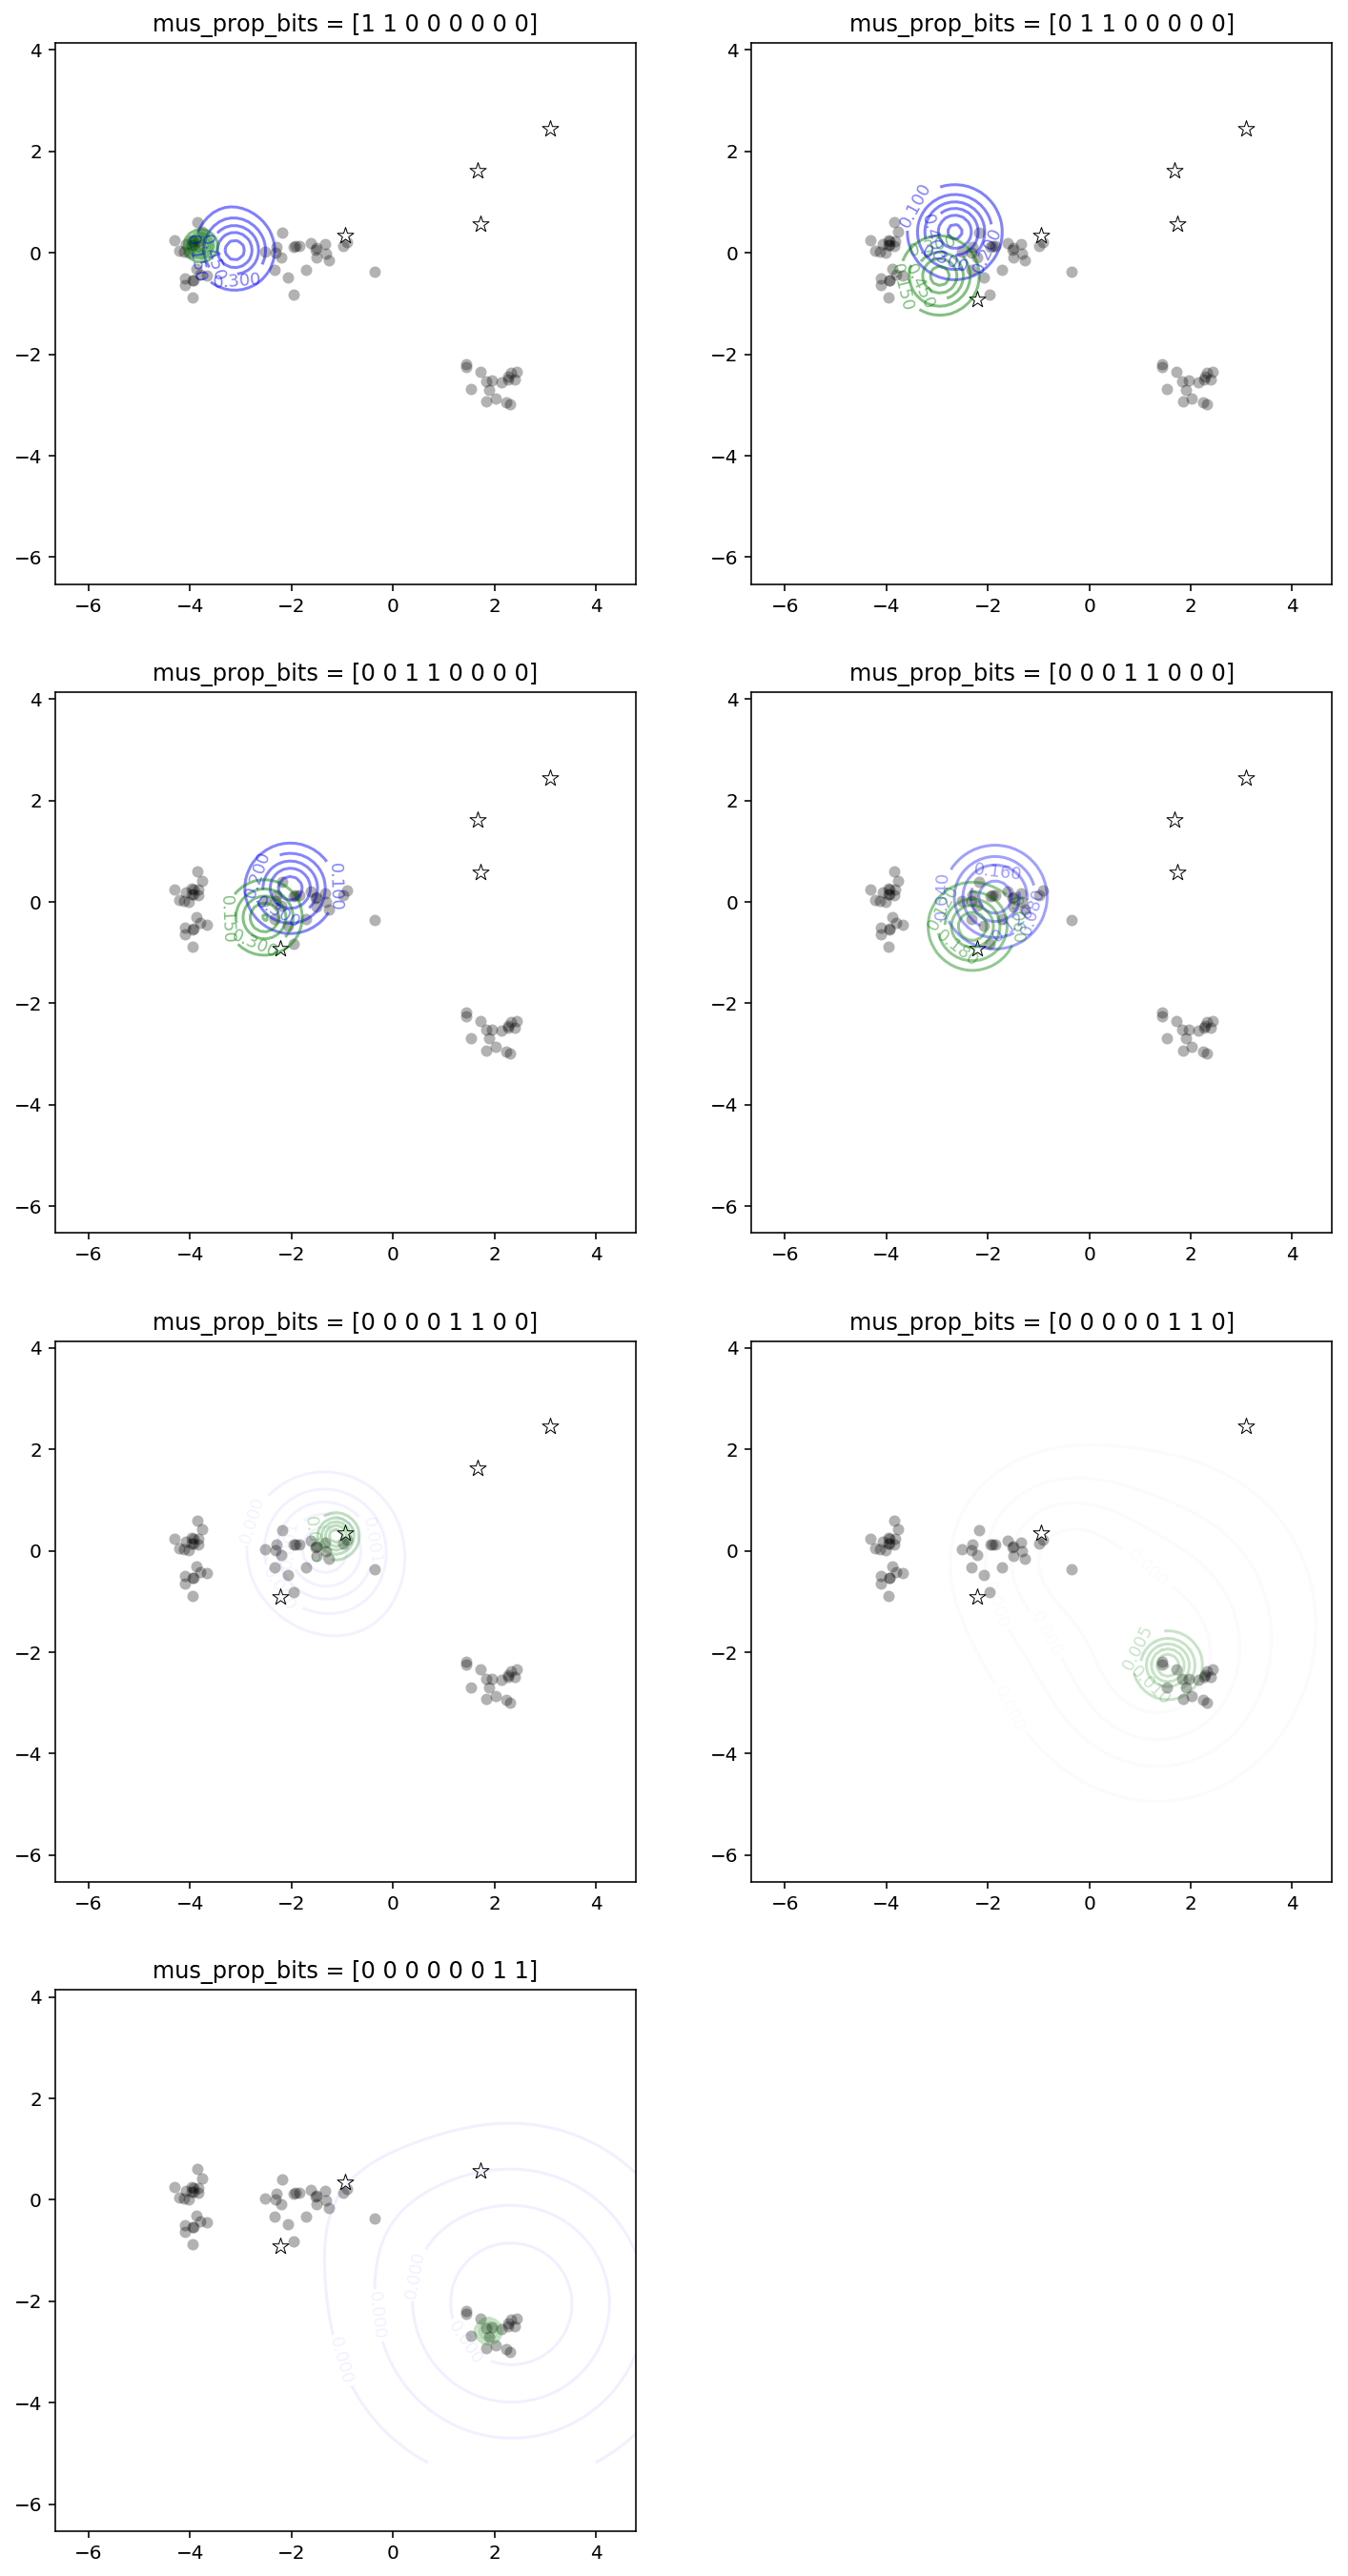

In [13]:
test_pretrain_visualize()

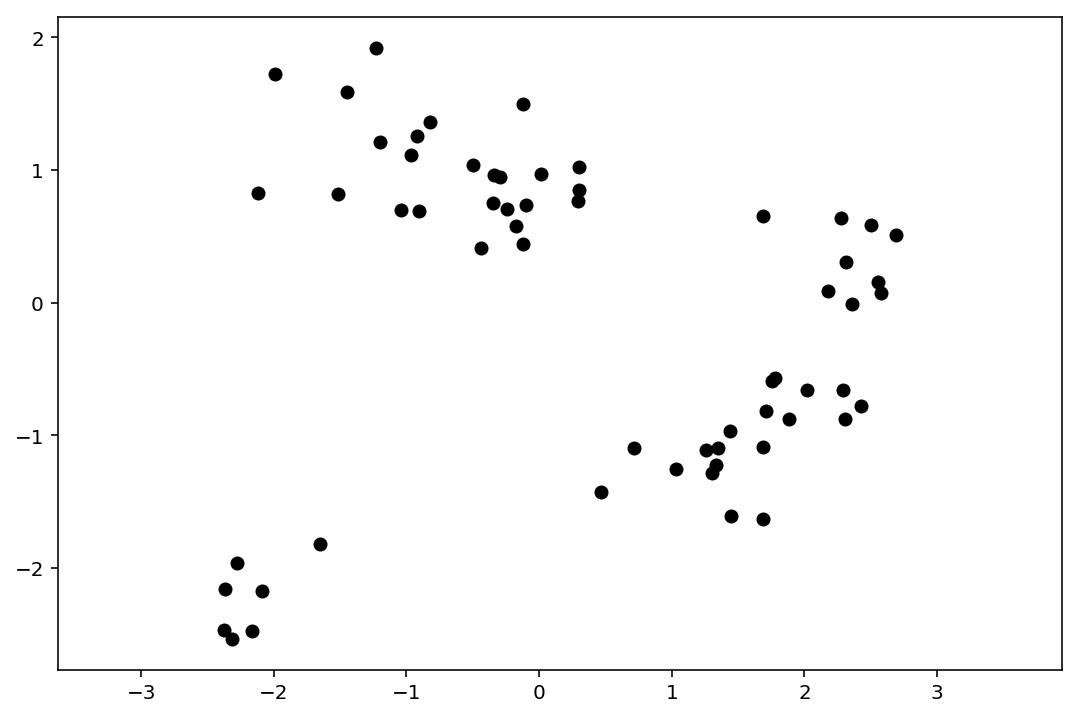

In [31]:
samples = Cs, mus, mus_valid_bits, zs, xs, Ws, offsets = sample(1, Cs = 6, sort_pca = True)
scatter_xs(xs)

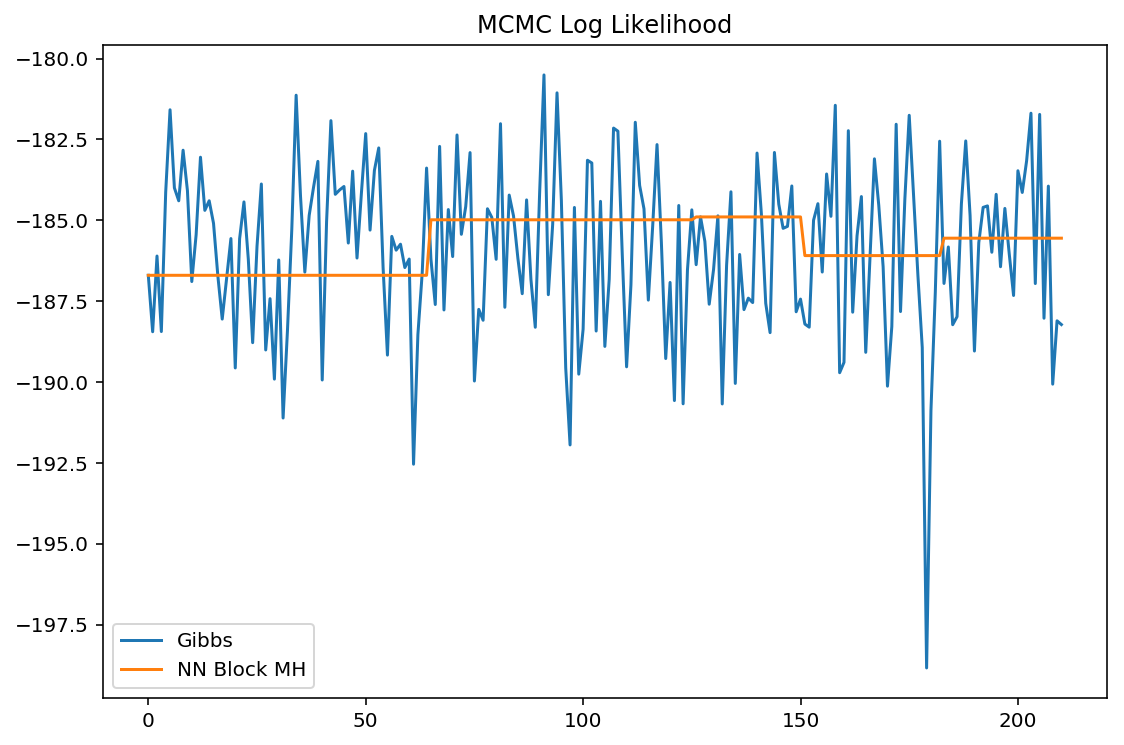

In [32]:
# ground truth initialization
compare_mcmc(
    xs, 
    init_fn = lambda: samples, 
    burn_in = 200, 
    num_samples = 1,
)

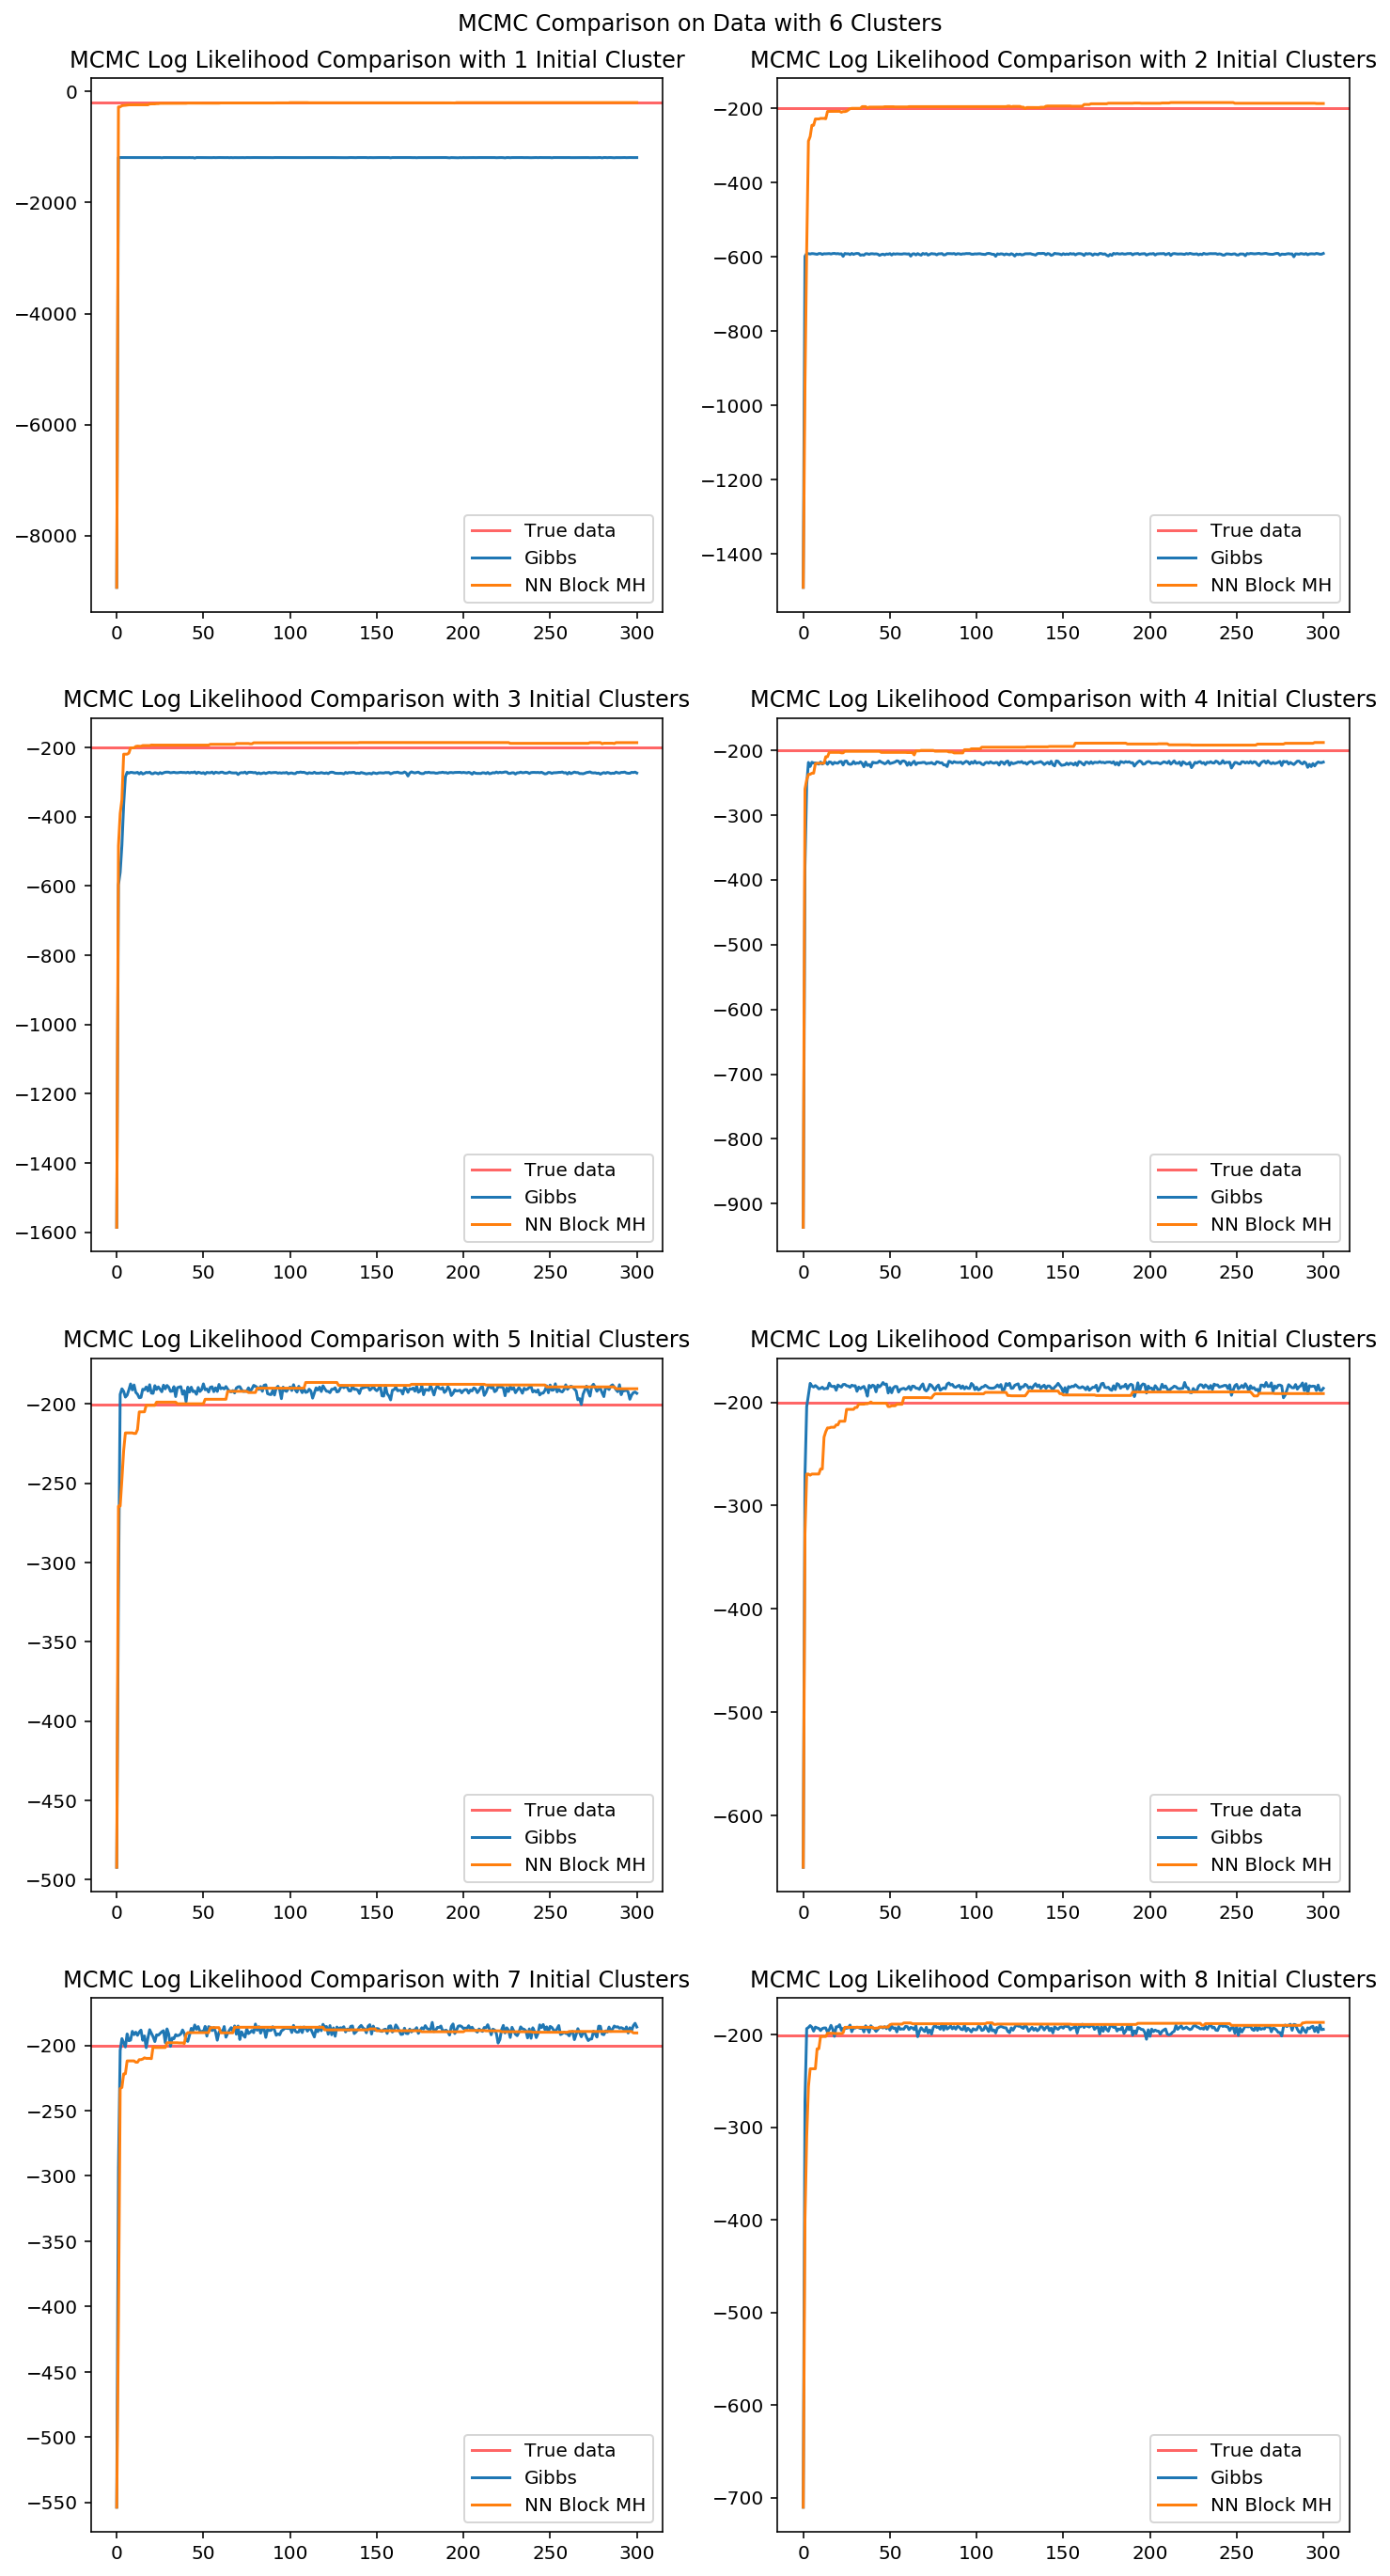

In [33]:
_ = compare_mcmc_different_init_clusters(
    samples,
    burn_in = 300,
    num_samples = 0,
)

In [34]:
K = 100

gibbs_params = {
    "burn_in": 500, 
    "num_samples": 5, 
    "sample_int": 20, 
    "plotter": None,
}

gibbs_fns = [gibbs, nn_block_mh]

gibbs_sample_colls = [[] for _ in gibbs_fns]

for gibbs_fn, gibbs_samples in zip(gibbs_fns, gibbs_sample_colls):
    print("Running {}...".format(gibbs_fn.__name__))
    for k in range(K):
        print("\r{}/{}".format(k, K), end = "")
        gibbs_samples.append(gibbs_fn(xs, **gibbs_params))
    print("\rdone!")
    sys.stdout.write("\033[K")

Running gibbs...
done!0
Running nn_block_mh...
done!0


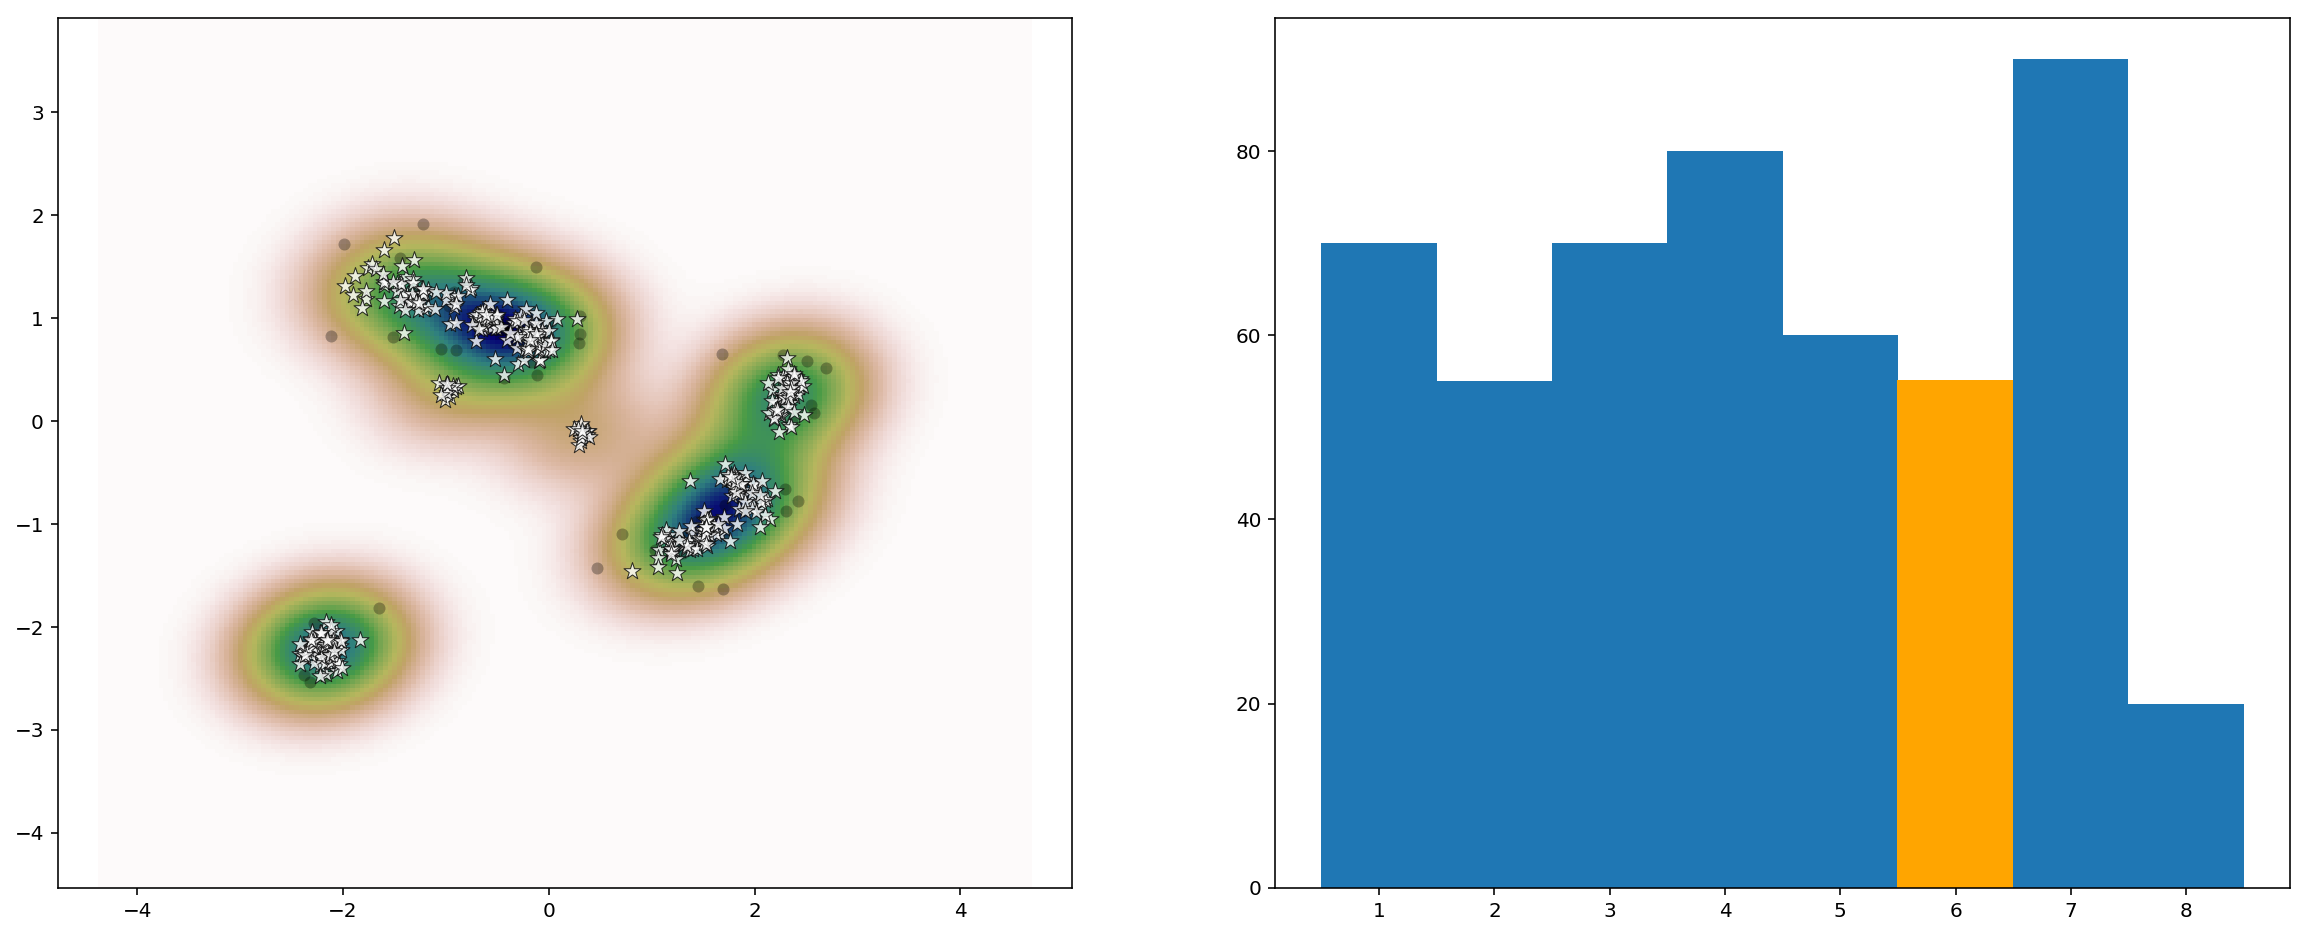

In [35]:
fig, axs = plt.subplots(1, 2, figsize= (20, 8))
sample_mus_kde(xs, gibbs_sample_colls[0], gaussian_bw = 0.3, delta = 200j, ax = axs[0])
sample_Cs_hist(Cs, gibbs_sample_colls[0], ax = axs[1])
plt.show()

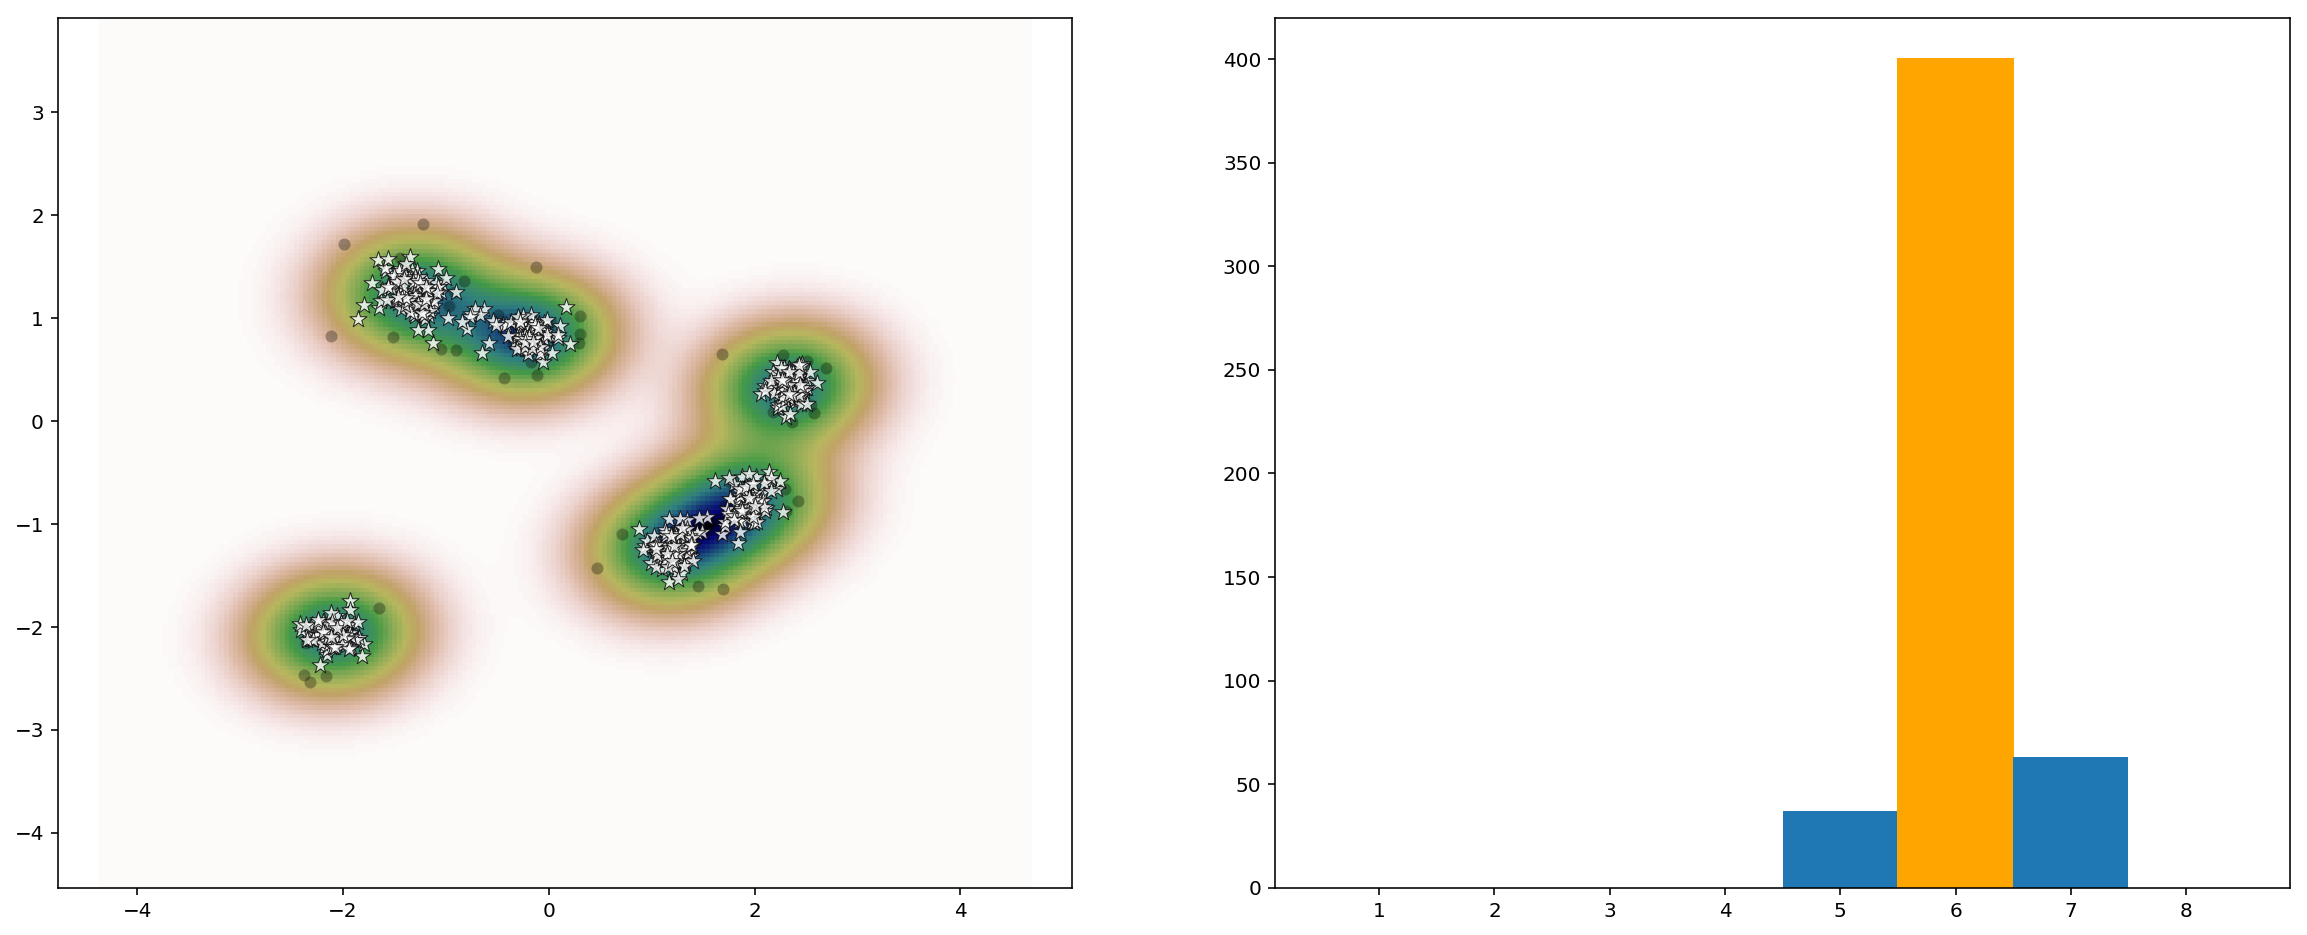

In [36]:
fig, axs = plt.subplots(1, 2, figsize= (20, 8))
sample_mus_kde(xs, gibbs_sample_colls[1], gaussian_bw = 0.3, delta = 200j, ax = axs[0])
sample_Cs_hist(Cs, gibbs_sample_colls[1], ax = axs[1])
plt.show()

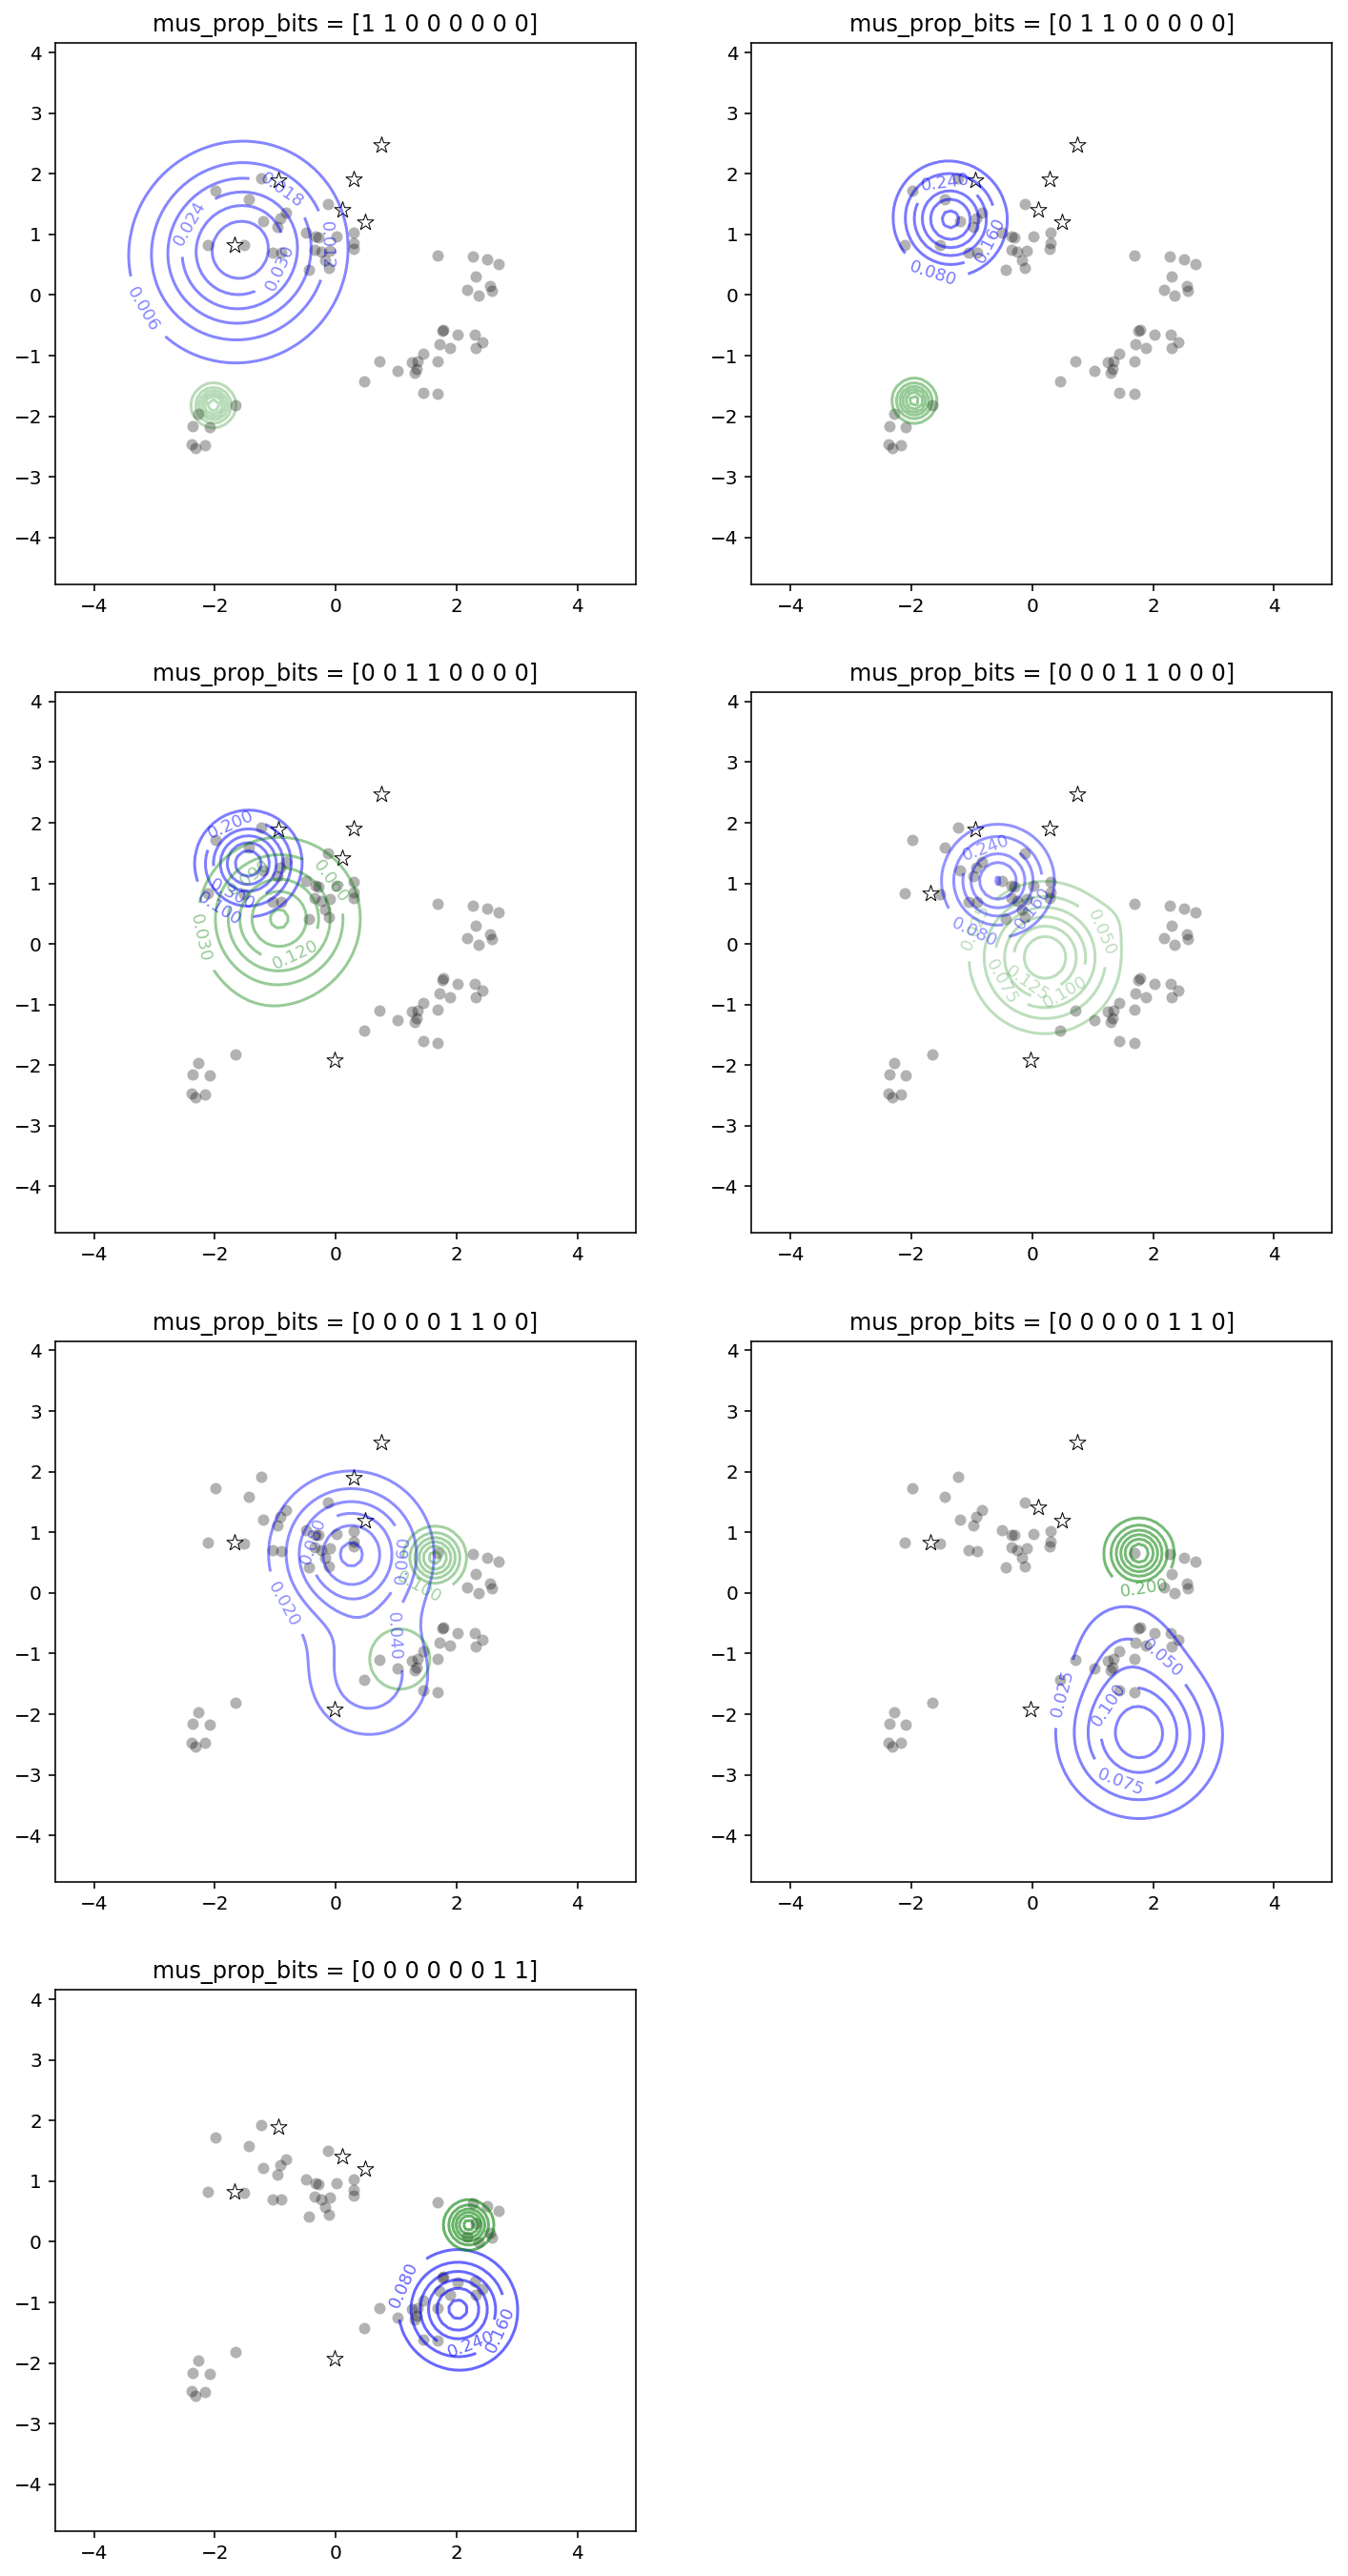

In [37]:
test_pretrain_visualize(true_samples = samples)